In [26]:
from flagmanager.data_loader.load import load_day
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adtk.data import validate_series
from adtk.transformer import RollingAggregate
from adtk.transformer import DoubleRollingAggregate
from adtk.visualization import plot
from adtk.detector import QuantileAD
from adtk.detector import PersistAD
from adtk.detector import InterQuartileRangeAD

In [167]:
dfs = load_day(2022,5,27, "CalL01", 
                            "Level1")
print(dfs.keys())
s=0
frame = dfs["Dobson_101"]["df"]
tmp = frame[frame["flag"]==0]


dict_keys(['Dobson_062', 'Dobson_101', 'Brewer_040', 'Brewer_072', 'Brewer_156', 'Brewer_163'])


[<Axes: >]

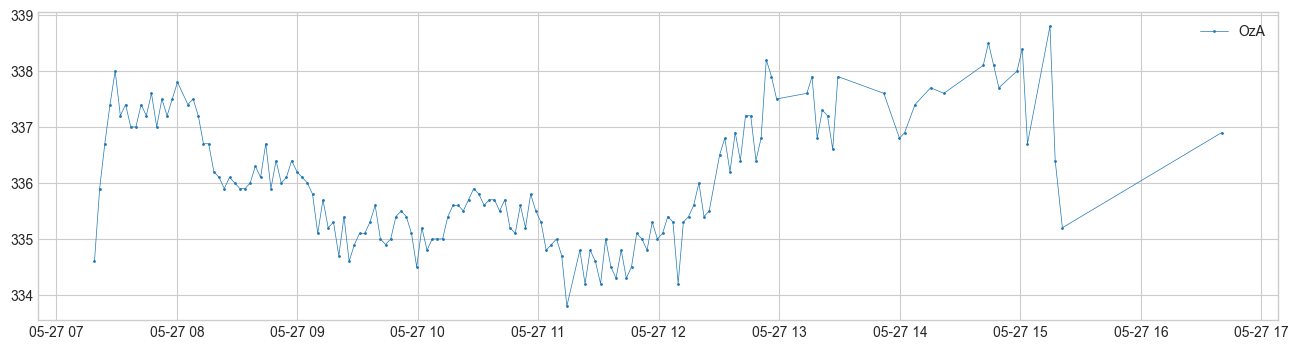

In [168]:

s = tmp[["timestamp","OzA"]]
s = s.set_index('timestamp')
s = validate_series(s)
plot(s)

timestamp
2022-05-27 05:27:59    False
2022-05-27 05:37:30     True
2022-05-27 05:46:36    False
2022-05-27 05:53:16    False
2022-05-27 06:04:42     True
                       ...  
2022-05-27 16:24:12     True
2022-05-27 16:27:16     True
2022-05-27 16:35:07     True
2022-05-27 16:37:42    False
2022-05-27 16:40:17    False
Name: OzA, Length: 210, dtype: bool

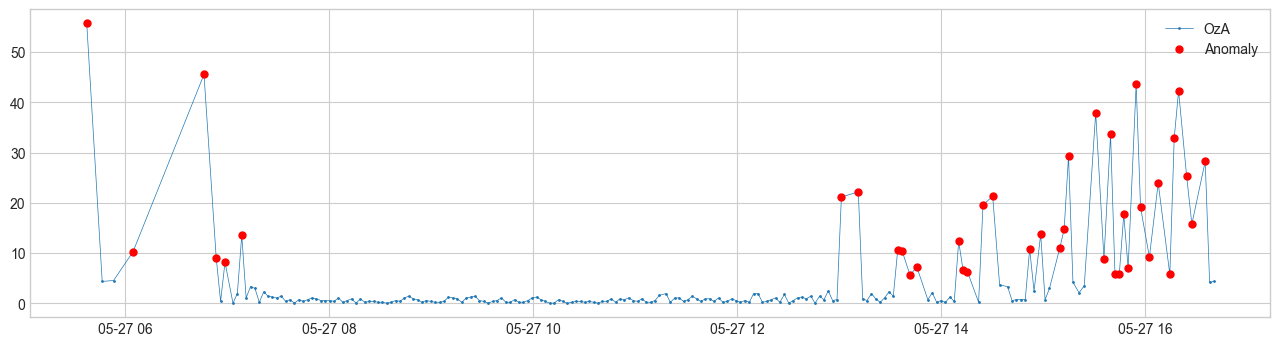

In [163]:
s_transformed = DoubleRollingAggregate(
    agg="quantile",
    agg_params={"q": [0.1, 0.5, 0.9]},
    window=1,
    diff="l2").transform(s)
std = s_transformed.std()

persist_ad = PersistAD(c=5, side='positive')
persist_ad.window = 10
anomalies = persist_ad.fit_detect(s_transformed)
anomalies = anomalies.fillna(True)
mask = s_transformed["OzA"]>=5.0
mask2 = s_transformed["OzA"]<=2*std[0]
plot(s_transformed,mask,anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")
mask


[<Axes: >]

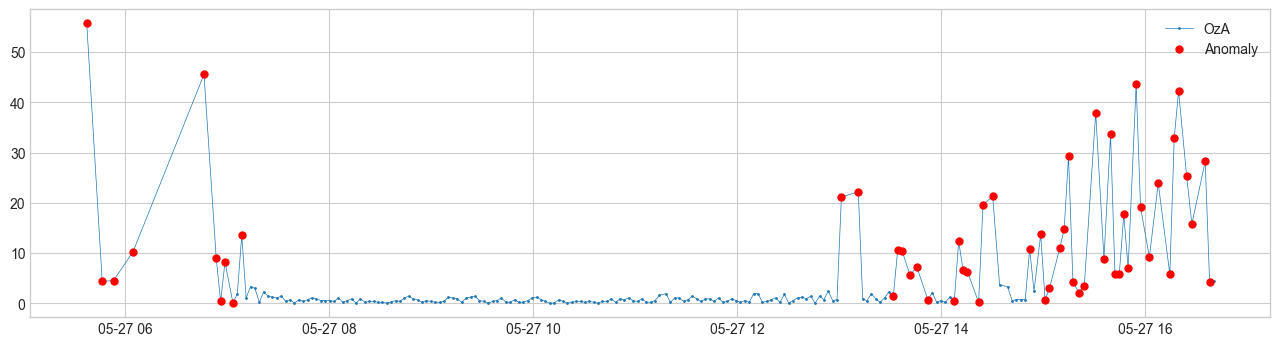

In [164]:
int_s = mask.astype(int)
int_s = mask.astype(int)

# Convolve with a kernel of size 5
kernel = np.ones(7, dtype=int)
convolved = np.convolve(int_s, kernel, mode='same')

# Set the center value of window (here, index 2 of each window) to True if sum is greater than or equal to 3
mask[(convolved >= 3)] = True
plot(s_transformed,mask,anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")

[<Axes: >]

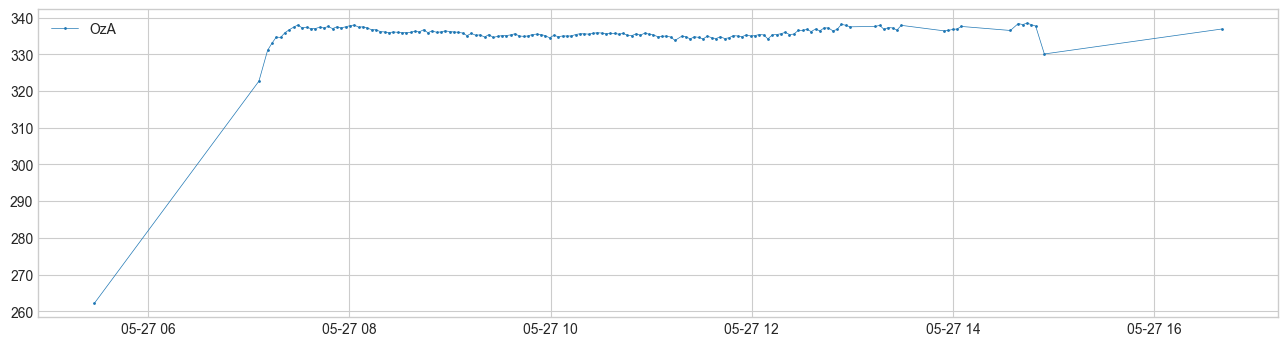

In [165]:
t = s[~mask].copy()
plot(t)

array([False, False, False, False, False, False, False, False, False,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

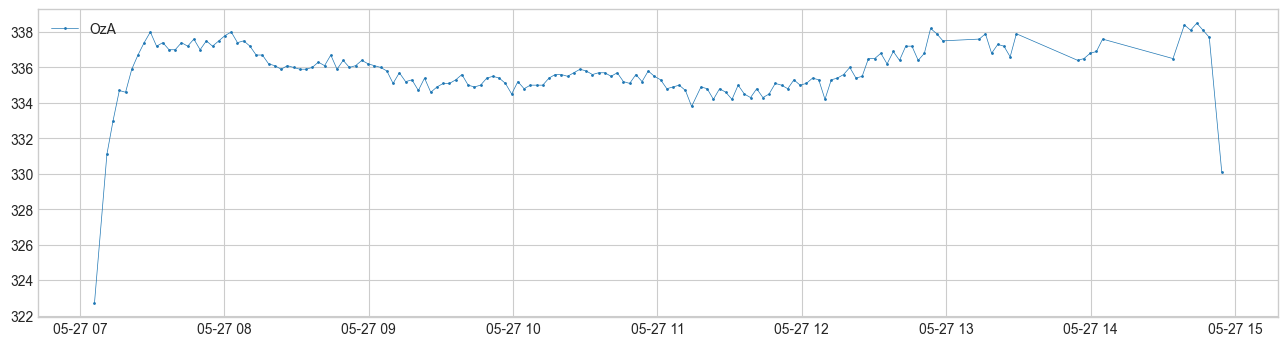

In [166]:
t['time_diff'] = t.index.to_series().diff().fillna(pd.Timedelta(seconds=0))
threshold = t['time_diff'].mean()*2
def is_isolated(index_pos, df):
    if index_pos == 0:  # First point
        return df.index[1] - df.index[0] > threshold
    elif index_pos == len(df) - 1:  # Last point
        return df.index[-1] - df.index[-2] > threshold
    else:
        prev_diff = df.index[index_pos] - df.index[index_pos-1]
        next_diff = df.index[index_pos+1] - df.index[index_pos]
        return prev_diff > threshold and next_diff > threshold

# Identify isolated points
isolated_points = [idx for idx in t.index if is_isolated(list(t.index).index(idx), t)]

# If fewer than 3 isolated points, remove them
if len(isolated_points) < 5:
    t = t.drop(isolated_points)
plot(t["OzA"])
mask3 = s.index.isin(t.index)
mask3

timestamp
2022-05-27 07:06:04    322.7
2022-05-27 07:11:14    331.1
2022-05-27 07:13:48    333.0
2022-05-27 07:16:24    334.7
2022-05-27 07:18:59    334.6
                       ...  
2022-05-27 14:41:32    338.1
2022-05-27 14:44:07    338.5
2022-05-27 14:46:43    338.1
2022-05-27 14:49:18    337.7
2022-05-27 14:54:29    330.1
Name: OzA, Length: 155, dtype: float64

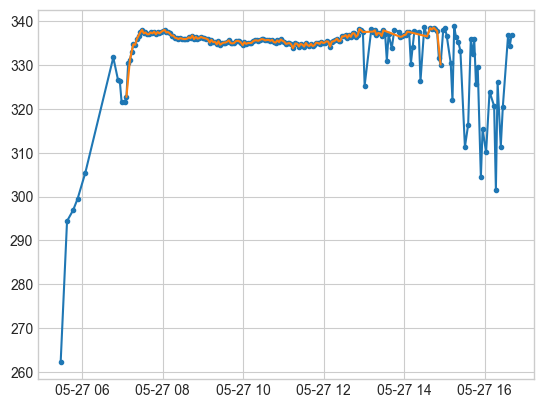

In [152]:
plt.plot(s, ".-")
plt.plot(t["OzA"])



In [83]:
s['time_diff'] = s.index.to_series().diff().fillna(pd.Timedelta(seconds=0))
s['time_diff_next'] = s.index.to_series().diff(1).fillna(pd.Timedelta(seconds=0))
delta = s['time_diff'].mean()*2
delta


Timedelta('0 days 00:06:24.171428570')

In [ ]:
s['time_diff'] = s['timestamp'].diff().fillna(pd.Timedelta(seconds=0))
s['time_diff_next'] = s['timestamp'].diff(-1).fillna(pd.Timedelta(seconds=0))

# Set a time threshold (e.g., 2 days)
threshold = pd.Timedelta(days=2)

# Identify isolated points
isolated_points = s[(s['time_diff'] > threshold) & (s['time_diff_next'].abs() > threshold)]

# If fewer than 3 isolated points, remove them
if len(isolated_points) < 3:
    df = df.drop(isolated_points.index)